# **Importing the data**

In [1]:
import os
import pandas as pd
import re 

def simplify_chord(chord):
    '''
    Function to simplify overspecific chords that would 
    add noise to the models. Input a chord, and the output is 
    the simplified version, if needed 
    '''
    # Remove extensions 
    chord = chord.split('/')[0]

    # Remove parentheses and extra notation
    chord = re.sub(r'[\(\)]', '', chord)

    # Make major chords the default ones 
    chord = chord.replace(':maj', '')

    # Simplify 7th chords 
    chord = re.sub(r':(7|9|11|13).*', r':7', chord)
    chord = re.sub(r':maj7.*', r':maj7', chord)
    chord = re.sub(r':min7.*', r':min7', chord)

    # Simplify dim7 or hdim7 to dim
    chord = re.sub(r':hdim7|:dim7', r':dim', chord)

    # Remove sus
    chord = re.sub(r':sus\d*', '', chord)

    # Clean
    chord = chord.strip(':').strip()

    return chord
    
# Path to dataset 
folder_path = r'.\McGill-Billboard'

# Read the files and enter a list of chords from each song into songs 
songs = []
single_chords = []
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename) + r'\salami_chords.txt'
    with open(file_path, 'r', encoding='utf-8') as song:

        # Get rid of title, artist, metre, and tonic 
        lines = song.readlines()
        filtered_lines = [line for line in lines if not line.lstrip().startswith('#')]
        filtered_text = "\n".join(filtered_lines)

        # Only keep the chords
        pattern =  r'[A-G][a-z]?(?::[0-9A-Za-z/]{0,6})?'
        chords = re.findall(pattern, filtered_text)
        simplified_chords = [simplify_chord(chord) for chord in chords]
        for chord in simplified_chords:
            if chord not in single_chords:
                single_chords.append(chord)
        songs.append(simplified_chords)

# Make the string a Pandas series 
song_series = pd.Series(songs).explode()

In [2]:
# Number of separate chords after simplifying 
len(single_chords)

189

In [3]:
song_series

0          A
0      A:min
0      A:min
0          C
0          C
       ...  
889       Cb
889       Cb
889       Cb
889       Cb
889       Cb
Length: 120839, dtype: object

In [4]:
# Giving each chord an integer for clarity, and finding the number of times each chord appears
# I also created int_to_song to look in the other direction 
chord_to_int = {}
int_to_chord = {}
chord_distribution = {}
chord_int = 0
for chord in song_series: 
    if chord not in chord_to_int:
        chord_to_int[chord] = chord_int
        int_to_chord[chord_int] = chord 
        chord_int += 1
        chord_distribution[chord] = 1
    else: 
        chord_distribution[chord] += 1

# Sample to print 
head_items = dict(list(chord_to_int.items())[:10])
head_items

{'A': 0,
 'A:min': 1,
 'C': 2,
 'B': 3,
 'F': 4,
 'D': 5,
 'G': 6,
 'Ab': 7,
 'Db': 8,
 'G:dim': 9}

In [5]:
# transforming song_series to have it use the integers 
int_series = song_series.map(chord_to_int)
int_series

0        0
0        1
0        1
0        2
0        2
      ... 
889    143
889    143
889    143
889    143
889    143
Length: 120839, dtype: int64

# **Visualizing the data**

In [6]:
# visualization of chord distribution
chord_distribution

# Sample to print 
head_items = dict(list(chord_distribution.items())[:10])
head_items

{'A': 10398,
 'A:min': 2515,
 'C': 12677,
 'B': 6015,
 'F': 9927,
 'D': 9508,
 'G': 9208,
 'Ab': 3398,
 'Db': 2049,
 'G:dim': 35}

In [7]:
import matplotlib.pyplot as plt
import numpy as np 

# zipping chord number with chord frequency, and using np to order 
zipped = zip(int_to_chord.keys(), chord_distribution.values())
all_chords = np.array(list(zipped))
ordered_chords = all_chords[all_chords[:, 1].argsort()[::-1]]
most_common_chords = 0
print(ordered_chords[:10])

[[    2 12677]
 [    0 10398]
 [    4  9927]
 [    5  9508]
 [    6  9208]
 [   20  6582]
 [    3  6015]
 [   28  4881]
 [    7  3398]
 [   15  2803]]


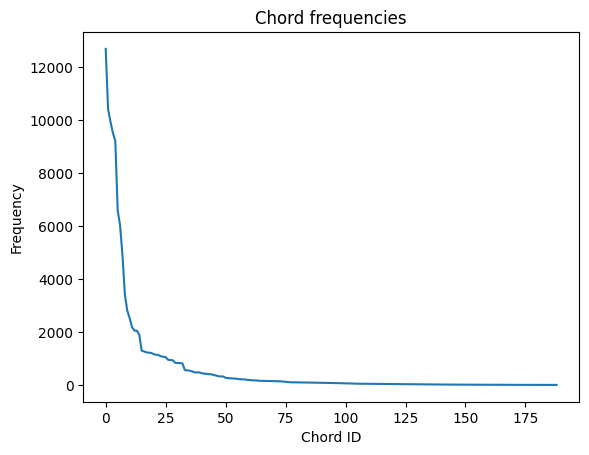

In [8]:
# visual representation of the number of chords. This shows that the chords are heavily skewed
plt.plot(range(len(ordered_chords)), list(ordered_chords[:, 1]))
plt.title('Chord frequencies')
plt.xlabel('Chord ID')
plt.ylabel('Frequency')
plt.show()
plt.show()

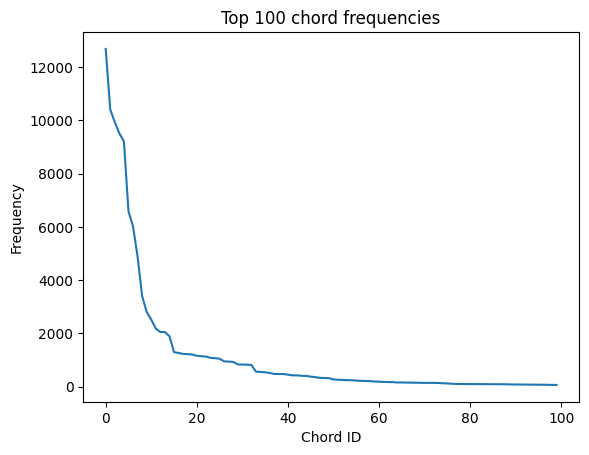

In [9]:
# Visual representation of the first 100 chord frequencies. From this visualisation, I will pick the 20 top chords
first_100 = ordered_chords[:100]
plt.plot(range(len(first_100)), list(first_100[:, 1]))
plt.title('Top 100 chord frequencies')
plt.xlabel('Chord ID')
plt.ylabel('Frequency')
plt.show()

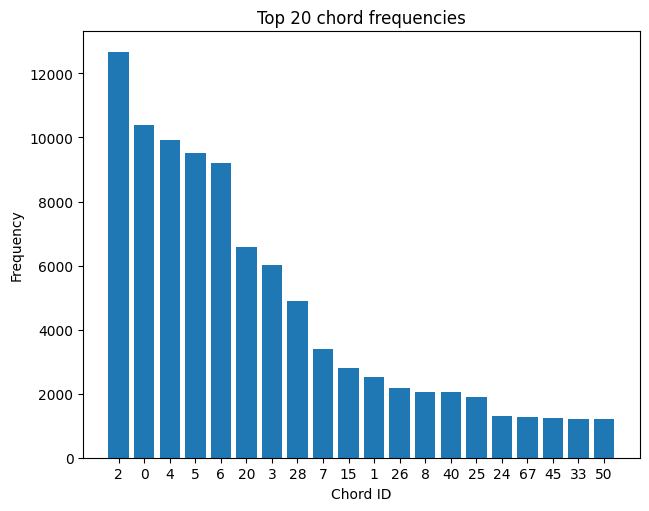

In [10]:
# bar graph representation of the 20 most common chords. As expected, the major scale is at the top. 

first_40 = ordered_chords[:20]

labels = list(first_40[:, 0])       
frequencies = list(first_40[:, 1])   

x_positions = range(len(labels))

plt.bar(x_positions, frequencies)
plt.xticks(x_positions, labels)  

plt.tight_layout()

plt.title('Top 20 chord frequencies')
plt.xlabel('Chord ID')
plt.ylabel('Frequency')

plt.show()

# **Applying Word2Vec and labeling**

In [11]:
# Word2Vec

from gensim.models import Word2Vec

vector_size = 50 

# Need list of lists
list_songs = song_series.groupby(song_series.index).apply(list).tolist()

# Train model 
w2v = Word2Vec(sentences=list_songs, vector_size=vector_size, window=2, min_count=1, workers=4, sg=1)

In [12]:
# Create labeled sequences of two chords

value = []
label = []

for song in list_songs:
    for i in range(len(song) - 2):
        value.append([song[i], song[i + 1]])
        label.append(song[i + 2])


In [13]:
# Turn values into Word2Vec vectors and labels into integers, 
# and insert them into X and y

X = []
y = []

for values, label in zip(value, label):
    
    X.append([w2v.wv[chord] for chord in values])
    y.append(chord_to_int[label])

# **Implementing GRU**

In [14]:
import torch
import torch.nn as nn

# 189 possible chords 
output_size = len(chord_distribution)

class GRUModel(nn.Module):
    def __init__(self, input_size=vector_size, hidden_size=64, num_layers=1, output_size=output_size):
        
        # Initialize parent class
        super().__init__()
        
        # Store hidden_size and num_layers
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Create GRU layer
        self.GRU = nn.GRU(input_size=input_size, 
                          hidden_size=hidden_size, 
                          num_layers=num_layers,
                          batch_first=True)
        
        # Create output layer
        self.fc = torch.nn.Linear(in_features=hidden_size, 
                                  out_features=output_size)
    
    def forward(self, x):
        
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Process through GRU
        output, hn = self.GRU(x, h0)
        
        # Project output
        final  = self.fc(hn[-1])
        return final 

In [15]:
from sklearn.model_selection import train_test_split

# Split the data into train and test 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Transform X_train to an np array because othewise it would cause a warning 
X_train = np.array(X_train) 
X_test = np.array(X_test)

# Transform values and labels to tensors for training data
X_tensor_train = torch.tensor(X_train, dtype=torch.float32)  
y_tensor_train = torch.tensor(y_train, dtype=torch.long)   

# Transform values and labels to tensors for testing data 
X_tensor_test = torch.tensor(X_test, dtype=torch.float32)  
y_tensor_test = torch.tensor(y_test, dtype=torch.long) 

# Initialize the model 
GRU_model = GRUModel()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(GRU_model.parameters(), lr=0.001)

In [16]:
# Training
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):

    # Tensor of randomly ordered indices to help generalize each epoch
    permutation = torch.randperm(X_tensor_train.size(0)) 

    # Loop through the data with steps of batch_size
    for i in range(0, X_tensor_train.size(0), batch_size):

        # Indices of the current batch
        indices = permutation[i:i+batch_size]

        # Get the correct X and y for the current batch 
        batch_x, batch_y = X_tensor_train[indices], y_tensor_train[indices]

        # Forward pass
        outputs = GRU_model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backpropagation 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 2.3805
Epoch [2/10], Loss: 3.1753
Epoch [3/10], Loss: 2.2496
Epoch [4/10], Loss: 2.2982
Epoch [5/10], Loss: 2.6257
Epoch [6/10], Loss: 2.2205
Epoch [7/10], Loss: 2.4715
Epoch [8/10], Loss: 2.0158
Epoch [9/10], Loss: 2.1970
Epoch [10/10], Loss: 2.1189


# **Testing GRU**

In [17]:
# See how often the model gives the correct prediction in one of 
# the three most likely predictions 

correct = 0
total = 0
true_correct = 0

GRU_model.eval()
with torch.no_grad():

    # Prediction and label for confusion matrix 
    y_pred_gru = []
    y_test_gru = []

    # Go through test data by batches of the same size as training
    for i in range(0, X_tensor_test.size(0), batch_size):
        batch_x = X_tensor_test[i:i+batch_size]
        batch_y = y_tensor_test[i:i+batch_size]
        outputs = GRU_model(batch_x)

        # Take the top 3 prediction 
        top_k_preds = torch.topk(outputs, 3, dim=1).indices
        
        # Check if one of the predictions was correct
        for true_label, top_preds in zip(batch_y, top_k_preds):
            if true_label in top_preds:
                correct += 1
            total += 1

        # Get the top prediction 
        top_pred = torch.topk(outputs, 1, dim=1).indices
        
        # Check if the top prediction was correct
        for true_label, top_pred in zip(batch_y, top_pred):
            if true_label == top_pred.item():
                true_correct += 1
            y_pred_gru.append(top_pred.item())
            y_test_gru.append(true_label.item())
            
print(f"Top guess Accuracy: {true_correct / total:.2%}")
print(f"Top-3 Accuracy: {correct / total:.2%}")


Top guess Accuracy: 36.92%
Top-3 Accuracy: 65.14%


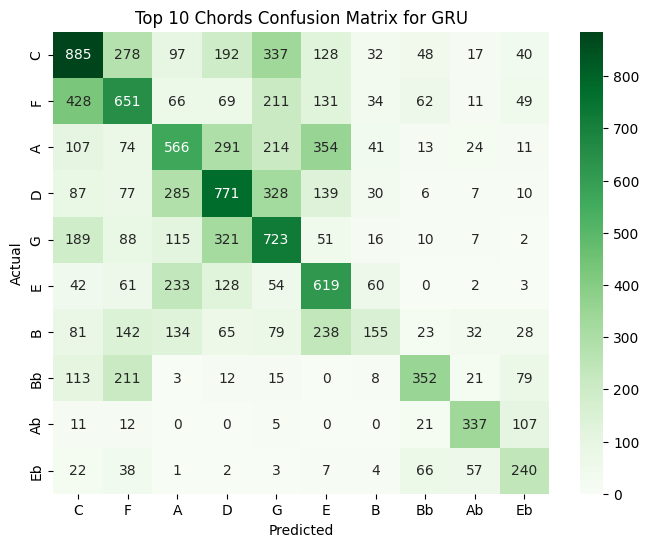

In [18]:
from sklearn.metrics import confusion_matrix
from collections import Counter
import seaborn as sns

# Find 10 most common chords in test data 
counts = Counter(y_test_gru)
top_10_ids = [ch for ch, _ in counts.most_common(10)]

# Only keep the top 10 from the confusion matrix 
filtered_y_test = []
filtered_y_pred = []

for true, pred in zip(y_test_gru, y_pred_gru):
    if true in top_10_ids:
        filtered_y_test.append(true)
        filtered_y_pred.append(pred)

# Build the confusion matrix 
cm = confusion_matrix(filtered_y_test, filtered_y_pred, labels=top_10_ids)

# Transform ints to chords 
labels = [int_to_chord[i] for i in top_10_ids]

# Plot with seaborn 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Top 10 Chords Confusion Matrix for GRU")
plt.show()

# **Using GRU**

In [53]:
def predict_chord(chord1, chord2, n=1, avoid_repetition=False):
    '''
    Takes two chords as strings and outputs the n chords that would be most likely played next.
    If avoid_repetition is True, only output chords different from the input
    '''
    # Simplify chords to match the training data 
    simplified_chord1 = simplify_chord(chord1)
    simplified_chord2 = simplify_chord(chord2)

    # Check that the chords exist in the set 
    if (simplified_chord1 not in chord_distribution.keys()):
        print(f'Chord {chord1} not available')
        return None
    
    if (simplified_chord2 not in chord_distribution.keys()):
        print(f'Chord {chord2} not available')
        return None  
        
    # Transform input chords into a tensor containing w2v arrays 
    input_chords = [simplified_chord1, simplified_chord2]
    input_vecs = [w2v.wv[chord] for chord in input_chords]
    input_vecs = np.array(input_vecs)
    input_tensor = torch.tensor([input_vecs], dtype=torch.float32)  
    
    GRU_model.eval()
    with torch.no_grad():
        # Apply tensor to the model 
        output = GRU_model(input_tensor)

        if avoid_repetition:
            # Takes the n+2 chords with highest probability 
            top_scores, top_indices = torch.topk(output, n+2, dim=1)
            initial_chord = [int_to_chord[i.item()] for i in top_indices[0]]
            
            # Replace the duplicated chords with the next best ones
            filtered_chord = [chord for chord in initial_chord if (chord != simplified_chord1) 
                              and (chord != simplified_chord2)]
            predicted_chord = filtered_chord[:n]
        
        else:
            # Takes the n chords with highest probability 
            top_scores, top_indices = torch.topk(output, n, dim=1)
            predicted_chord = [int_to_chord[i.item()] for i in top_indices[0]]
    
    return predicted_chord 

In [54]:
# Example uses 

# Common progressions  
print('Next chord prediction: ', predict_chord('C:maj', 'G:maj'))    
print('Next chord prediction: ', predict_chord('G:maj', 'D:maj', 3))   
print('Next chord prediction: ', predict_chord('A:min', 'F:maj', 3, True))     
print()

# Minor key progressions 
print('Next chord prediction: ', predict_chord('E:min', 'A:min'))    
print('Next chord prediction: ', predict_chord('D:min', 'G:min', 3))            
print('Next chord prediction: ', predict_chord('B:min', 'F:maj', 3, True))                 
print()

# Rare progressions 
print('Next chord prediction: ', predict_chord('Db:maj/5', 'Ab:maj'))  
print('Next chord prediction: ', predict_chord('F:maj', 'Bdim', 3))         # With unavailable chord 
print('Next chord prediction: ', predict_chord('D:7', 'Ab:maj', 3, True))     


Next chord prediction:  ['G']
Next chord prediction:  ['D', 'G', 'C']
Next chord prediction:  ['G', 'E:min', 'D:min']

Next chord prediction:  ['A:min']
Next chord prediction:  ['G:min', 'C', 'Bb']
Next chord prediction:  ['A', 'B', 'D']

Next chord prediction:  ['Ab']
Chord Bdim not available
Next chord prediction:  None
Next chord prediction:  ['Bb', 'G', 'G:min']


# **Implementing K-Means**

In [21]:
from sklearn.cluster import KMeans

# Elbow method function to find ideal number of clusters 
def plot_distortions(data):
    distortions = []
    for i in range(1, 11):
        km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
        km.fit(data)
        distortions.append(km.inertia_)
    plt.plot(range(1, 11), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.tight_layout()
    plt.show()

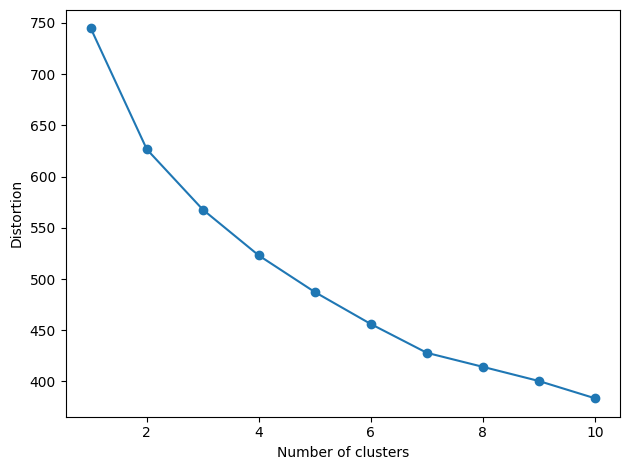

In [22]:
# Transform each chord into a w2v vector
single_chords_vectors = np.array([w2v.wv[chord] for chord in single_chords])

plot_distortions(single_chords_vectors)

In [23]:
# Fit kmeans. While light, elbow seems to be at 3, and it has less noise than 4
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(single_chords_vectors)

# Tuples of chords and their clusters 
chord_cluster = zip(single_chords, kmeans.labels_)

# Create dictionaries to go from chord to clusters and vice versa 
cluster_to_chord = {}
chord_to_cluster = {}

for chord, cluster in chord_cluster:
    
    # Populate cluster_to_chord
    if cluster not in cluster_to_chord:
        cluster_to_chord[cluster] = [chord]
    else: 
        cluster_to_chord[cluster].append(chord)

    # Populate chord_to_cluster
    chord_to_cluster[chord] = cluster
    
for cluster, chord in cluster_to_chord.items():
    print(f'List of chords in cluster {cluster}: \n{chord}\n')

List of chords in cluster 0: 
['A', 'A:min', 'C', 'B', 'F', 'D', 'G', 'E', 'E:min', 'A6', 'E:7', 'B:min', 'G7', 'C7', 'B:7', 'E:min7', 'A:7', 'D7', 'D6', 'D:7', 'B:min7', 'D:5', 'A:5', 'B:5', 'B7', 'A:min7', 'D:1', 'A9', 'E7', 'A7', 'A:1', 'E:min9', 'E:5', 'G9', 'B:1', 'E:1', 'F9', 'F7', 'C9', 'D:min6', 'G6', 'D9', 'B:min9', 'E:aug', 'B6', 'E:min11', 'E6', 'E:minmaj']

List of chords in cluster 2: 
['Ab', 'Db', 'Bb:min7', 'Eb:7', 'Ab:7', 'Ab7', 'Gb', 'Db7', 'Gb:7', 'F:min7', 'Db:min', 'Gb6', 'F:min9', 'Bb:min', 'Eb:min', 'Db:7', 'Ab:min7', 'Eb:min9', 'Ab:1', 'Ab:min9', 'Gb7', 'Eb6', 'Ab6', 'Ab:min', 'Db6', 'Gb:min', 'Gb:1', 'Eb:1', 'Eb:min7', 'Db:1', 'Cb7', 'Gb9', 'Cb:7', 'A:min6', 'Db:min7', 'Db9', 'Bb:min9', 'Cb', 'Fb', 'Eb:min11', 'Ab:min11', 'Ab:min6', 'Db:min9', 'Bb:min11']

List of chords in cluster 1: 
['G:dim', 'C:7', 'F:min', 'C:min7', 'Eb', 'C:5', 'G:7', 'D:min', 'G:min7', 'Bb', 'D:min7', 'C:min', 'A:dim', 'C6', 'D13', 'G:min', 'Eb:5', 'F:5', 'G:5', 'Bb:5', 'F:7', 'Bb:7', 'Ab

# **Labeling K-Means clusters**

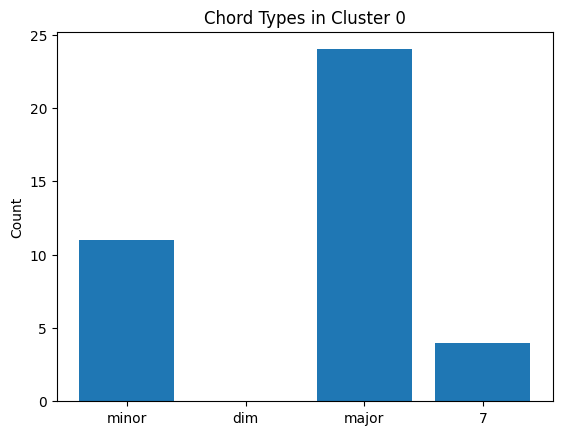

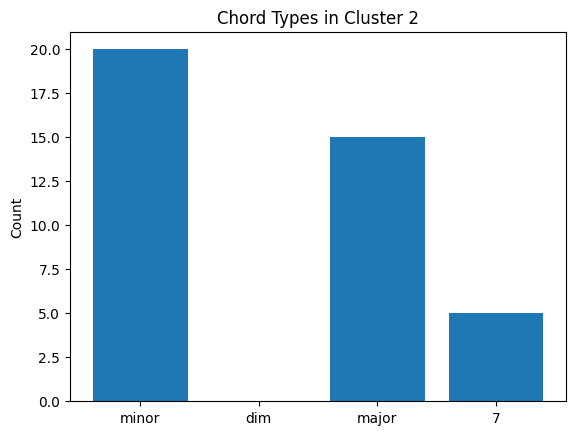

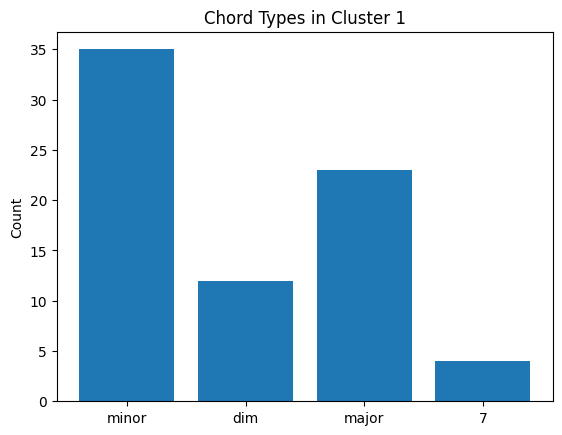

In [24]:
for cluster_id, chords in cluster_to_chord.items():
    labels = ['minor', 'dim', 'major', '7']

    counts = [
        
    # Number of minor chords 
    sum(':min' in ch for ch in chords),

    # Number of diminished chords 
    sum(':dim' in ch or 'hdim' in ch for ch in chords),

    # Number of major chords 
    sum(':maj' in ch or (':' not in ch) for ch in chords),

    # Number of 7th chords
    sum(':7' in ch for ch in chords)

    ]
    
    plt.bar(labels, counts)
    plt.title(f"Chord Types in Cluster {cluster_id}")
    plt.ylabel("Count")
    plt.show()

In [25]:
# Dictionary labeling the clusters
cluster_to_label = {0: 'Common chords', 1: 'Complex chords', 2: 'Minor chords'}

# **Visualizing K-Means**

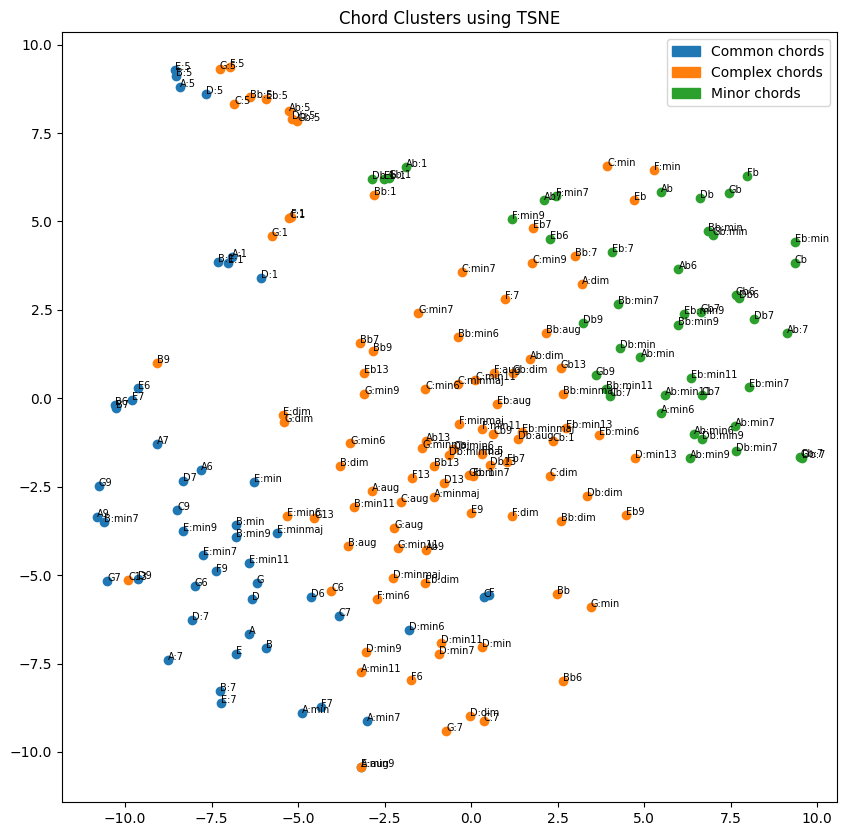

In [26]:
# Graphical representation of the clusters 

import matplotlib.patches as mpatches
from sklearn.manifold import TSNE

# Use TSNE to plot the chords 
tsne = TSNE(n_components=2, random_state=42)
reduced = tsne.fit_transform(single_chords_vectors)

# Create color patches for the legend 
patches = [
    mpatches.Patch(color=f"C{cluster}", label=label)
    for cluster, label in cluster_to_label.items()
]

# Plot
plt.figure(figsize=(10, 10))
for i, chord in enumerate(single_chords):
    cluster_id = kmeans.labels_[i]
    plt.scatter(reduced[i, 0], reduced[i, 1], c=f"C{cluster_id}")
    plt.text(reduced[i, 0], reduced[i, 1], chord, fontsize=7)

plt.title("Chord Clusters using TSNE")
plt.legend(handles=patches)
plt.show()

# **Implementing Random Forest Classifier**

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Create labeled sequences of two chords
# X also contains cluster information for each chord 

X = []
y = []

for song in list_songs:
    for i in range(len(song) - 2):
        X.append([chord_to_int[song[i]], 
                  chord_to_int[song[i + 1]], 
                  chord_to_cluster[song[i]], 
                  chord_to_cluster[song[i + 1]]])
        
        y.append(chord_to_int[song[i + 2]])

# Split data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initiate the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# **Testing Random Forest Classifier**

In [28]:
# Getting the 3 most likely chords for every two chords 
probs = rf.predict_proba(X_test)
top3 = np.argsort(probs, axis=1)[:, -3:]

correct = 0

# Count how many times the correct label was in the predicted 3
for i in range(len(y_test)):
    true_label = y_test[i]
    predicted_top3 = top3[i]
    
    if true_label in predicted_top3:
        correct += 1

# Get the top prediction 
top = np.argsort(probs, axis=1)[:, -1:]

true_correct = 0

# Check if the top prediction was correct
for i in range(len(y_test)):
    true_label = y_test[i]
    predicted_top = top[i]
    
    if true_label == predicted_top:
        true_correct += 1

print(f"Top guess Accuracy: {true_correct / len(y_test):.2%}")
print(f"Top-3 Accuracy: {correct / len(y_test):.2%}")

Top guess Accuracy: 39.50%
Top-3 Accuracy: 68.53%


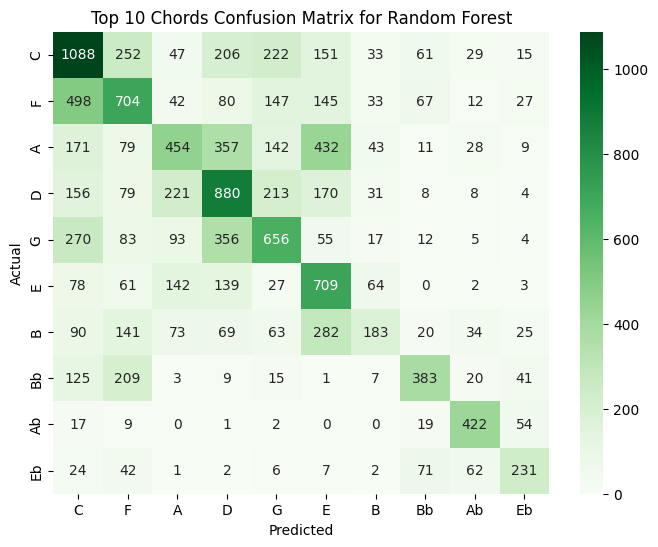

In [29]:
# Predict using Random Forest
y_pred = rf.predict(X_test)

# Find 10 most common chords in test data 
counts = Counter(y_test)
top_10_ids = [ch for ch, _ in counts.most_common(10)]

# Only keep the top 10 from the confusion matrix 
filtered_y_test = []
filtered_y_pred = []

for true, pred in zip(y_test, y_pred):
    if true in top_10_ids:
        filtered_y_test.append(true)
        filtered_y_pred.append(pred)

# Build the confusion matrix 
cm = confusion_matrix(filtered_y_test, filtered_y_pred, labels=top_10_ids)

# Transform ints to chords 
labels = [int_to_chord[i] for i in top_10_ids]

# Plot with seaborn 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Top 10 Chords Confusion Matrix for Random Forest")
plt.show()

# **Using Random Forest Classifier**

In [30]:
def predict_chord_rf(chord1, chord2, n=1, avoid_repetition=False):
    '''
    Takes two chords as strings and outputs the n chords that would be most likely played next.
    If avoid_repetition is True, only output chords different from the input
    '''
    # Simplify chords to match the training data 
    simplified_chord1 = simplify_chord(chord1)
    simplified_chord2 = simplify_chord(chord2)

    
    # Check that the chords exist in the set 
    if (simplified_chord1 not in chord_distribution.keys()):
        print(f'Chord {chord1} not available')
        return None
    
    if (simplified_chord2 not in chord_distribution.keys()):
        print(f'Chord {chord2} not available')
        return None 

    # Get the input chord's clusters 
    cluster1 = chord_to_cluster[simplified_chord1]
    cluster2 = chord_to_cluster[simplified_chord2]
    
    # Put simplified chords and their cluster in a list to pass it to the model 
    vec = [[chord_to_int[simplified_chord1], 
            chord_to_int[simplified_chord2], 
            cluster1, 
            cluster2]]
    
    probs = rf.predict_proba(vec)

    if avoid_repetition:
        # Takes the n+2 chords with highest probability 
        top_indices = np.argsort(probs[0])[::-1]
        initial_chord = [int_to_chord[i] for i in top_indices]
        
        # Replace the duplicated chords with the next best ones
        filtered_chord = [chord for chord in initial_chord if (chord != simplified_chord1) 
                          and (chord != simplified_chord2)]
        predicted_chord = filtered_chord[:n]
    
    else: 
        # Takes the n chords with highest probability 
        top_indices = np.argsort(probs[0])[-n:][::-1]
        predicted_chord = [int_to_chord[i] for i in top_indices]

    return predicted_chord

In [31]:
# Example uses 

# Common progressions  
print('Next chord prediction: ',predict_chord_rf('C:maj', 'G:maj'))    
print('Next chord prediction: ',predict_chord_rf('G:maj', 'D:maj', 3))   
print('Next chord prediction: ',predict_chord_rf('A:min', 'F:maj', 3, True))     
print()

# Minor key progressions 
print('Next chord prediction: ',predict_chord_rf('E:min', 'A:min'))    
print('Next chord prediction: ',predict_chord_rf('D:min', 'G:min', 3))            
print('Next chord prediction: ',predict_chord_rf('B:min', 'F:maj', 3, True))                 
print()

# Rare progressions 
print('Next chord prediction: ', predict_chord_rf('Db:maj/5', 'Ab:maj'))  
print('Next chord prediction: ',predict_chord_rf('F:maj', 'Bdim', 3))         # With unavailable chord 
print('Next chord prediction: ',predict_chord_rf('D:7', 'Ab:maj', 3, True))    

Next chord prediction:  ['C']
Next chord prediction:  ['D', 'G', 'C']
Next chord prediction:  ['G', 'E:min', 'D:min']

Next chord prediction:  ['A:min']
Next chord prediction:  ['G:min', 'Bb', 'C']
Next chord prediction:  ['A', 'A:7', 'D']

Next chord prediction:  ['Ab']
Chord Bdim not available
Next chord prediction:  None
Next chord prediction:  ['G:7', 'Bb', 'G']


# **Tuning GRU**

# **Tuning labeling**

In [32]:
# Create labeled sequences of two chords

value3 = []
label3 = []

for song in list_songs:
    for i in range(len(song) - 3):
        value3.append([song[i], song[i + 1], song[i + 2]])
        label3.append(song[i + 3])

In [33]:
# Turn values into Word2Vec vectors and labels into integers, 
# and insert them into X and y

X3_GRU = []
y3 = []

for values, label in zip(value3, label3):
    
    X3_GRU.append([w2v.wv[chord] for chord in values])
    y3.append(chord_to_int[label])

# **Implementing new GRU**

In [34]:
# 189 possible chords 
output_size = len(chord_distribution)

class GRUModel3(nn.Module):
    def __init__(self, input_size=vector_size, hidden_size=64, num_layers=1, output_size=output_size):
        
        # Initialize parent class
        super().__init__()
        
        # Store hidden_size and num_layers
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Create GRU layer
        self.GRU = nn.GRU(input_size=input_size, 
                          hidden_size=hidden_size, 
                          num_layers=num_layers,
                          batch_first=True)
        
        # Create output layer
        self.fc = torch.nn.Linear(in_features=hidden_size, 
                                  out_features=output_size)
    
    def forward(self, x):
        
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Process through GRU
        output, hn = self.GRU(x, h0)
        
        # Project output
        final  = self.fc(hn[-1])
        return final 

In [35]:
# Split the data into train and test 
X_train_GRU3, X_test_GRU3, y_train_GRU3, y_test_GRU3 = train_test_split(
    X3_GRU, y3, test_size=0.2, random_state=42
)

# Transform X_train to an np array because othewise it would cause a warning 
X_train_GRU3 = np.array(X_train_GRU3) 
X_test_GRU3 = np.array(X_test_GRU3)

# Transform values and labels to tensors for training data
X_tensor_train3 = torch.tensor(X_train_GRU3, dtype=torch.float32)  
y_tensor_train3 = torch.tensor(y_train_GRU3, dtype=torch.long)   

# Transform values and labels to tensors for testing data 
X_tensor_test3 = torch.tensor(X_test_GRU3, dtype=torch.float32)  
y_tensor_test3 = torch.tensor(y_test_GRU3, dtype=torch.long) 

# Initialize the model 
GRU_model3 = GRUModel3()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(GRU_model3.parameters(), lr=0.001)

In [36]:
# Training
num_epochs = 30
batch_size = 32

for epoch in range(num_epochs):

    # Tensor of randomly ordered indices to help generalize each epoch
    permutation = torch.randperm(X_tensor_train3.size(0)) 

    # Loop through the data with steps of batch_size
    for i in range(0, X_tensor_train3.size(0), batch_size):

        # Indices of the current batch
        indices = permutation[i:i+batch_size]

        # Get the correct X and y for the current batch 
        batch_x, batch_y = X_tensor_train3[indices], y_tensor_train3[indices]

        # Forward pass
        outputs = GRU_model3(batch_x)
        loss = criterion(outputs, batch_y)

        # Backpropagation 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/30], Loss: 2.2381
Epoch [2/30], Loss: 2.3757
Epoch [3/30], Loss: 2.6306
Epoch [4/30], Loss: 2.6787
Epoch [5/30], Loss: 2.6081
Epoch [6/30], Loss: 2.0525
Epoch [7/30], Loss: 2.0103
Epoch [8/30], Loss: 0.7929
Epoch [9/30], Loss: 1.8098
Epoch [10/30], Loss: 2.2998
Epoch [11/30], Loss: 1.4794
Epoch [12/30], Loss: 1.1054
Epoch [13/30], Loss: 2.5114
Epoch [14/30], Loss: 1.5631
Epoch [15/30], Loss: 2.9198
Epoch [16/30], Loss: 2.5588
Epoch [17/30], Loss: 2.1247
Epoch [18/30], Loss: 2.1364
Epoch [19/30], Loss: 1.6115
Epoch [20/30], Loss: 2.9426
Epoch [21/30], Loss: 2.5721
Epoch [22/30], Loss: 1.3522
Epoch [23/30], Loss: 2.4214
Epoch [24/30], Loss: 1.9815
Epoch [25/30], Loss: 1.2572
Epoch [26/30], Loss: 1.7777
Epoch [27/30], Loss: 1.5626
Epoch [28/30], Loss: 1.1354
Epoch [29/30], Loss: 1.0112
Epoch [30/30], Loss: 1.3340


# **Testing new GRU**

In [37]:
# See how often the model gives the correct prediction in one of 
# the three most likely predictions 

correct = 0
total = 0
true_correct = 0

GRU_model3.eval()
with torch.no_grad():

    # Prediction and label for confusion matrix 
    y_pred_gru3 = []
    y_test_gru3 = []

    # Go through test data by batches of the same size as training
    for i in range(0, X_tensor_test3.size(0), batch_size):
        batch_x = X_tensor_test3[i:i+batch_size]
        batch_y = y_tensor_test3[i:i+batch_size]
        outputs = GRU_model3(batch_x)

        # Take the top 3 prediction 
        top_k_preds = torch.topk(outputs, 3, dim=1).indices
        
        # Check if one of the predictions was correct
        for true_label, top_preds in zip(batch_y, top_k_preds):
            if true_label in top_preds:
                correct += 1
            total += 1

        # Get the top prediction 
        top_pred = torch.topk(outputs, 1, dim=1).indices
        
        # Check if the top prediction was correct
        for true_label, top_pred in zip(batch_y, top_pred):
            if true_label == top_pred.item():
                true_correct += 1
            y_pred_gru3.append(top_pred.item())
            y_test_gru3.append(true_label.item())
            
print(f"Top guess Accuracy: {true_correct / total:.2%}")
print(f"Top-3 Accuracy: {correct / total:.2%}")

Top guess Accuracy: 49.64%
Top-3 Accuracy: 74.63%


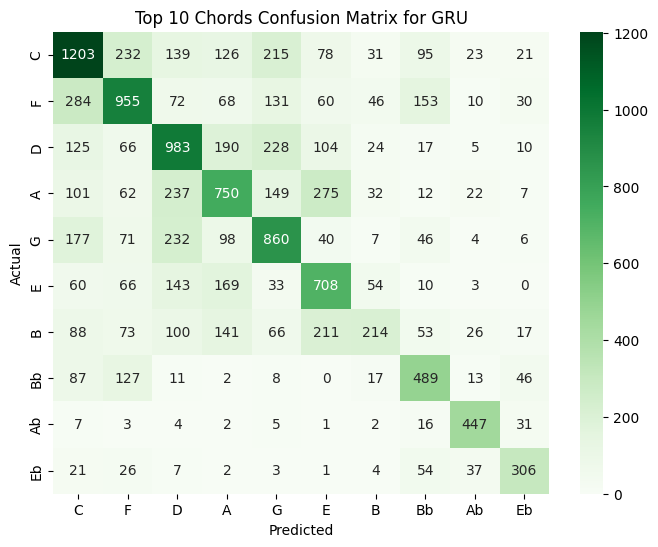

In [38]:
# Find 10 most common chords in test data 
counts = Counter(y_test_gru3)
top_10_ids = [ch for ch, _ in counts.most_common(10)]

# Only keep the top 10 from the confusion matrix 
filtered_y_test = []
filtered_y_pred = []

for true, pred in zip(y_test_gru3, y_pred_gru3):
    if true in top_10_ids:
        filtered_y_test.append(true)
        filtered_y_pred.append(pred)

# Build the confusion matrix 
cm = confusion_matrix(filtered_y_test, filtered_y_pred, labels=top_10_ids)

# Transform ints to chords 
labels = [int_to_chord[i] for i in top_10_ids]

# Plot with seaborn 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Top 10 Chords Confusion Matrix for GRU")
plt.show()

# **Using new GRU**

In [39]:
def predict_chord(chord1, chord2, chord3, n=1, avoid_repetition=False):
    '''
    Takes three chords as strings and outputs the n chords that would be most likely played next.
    If avoid_repetition is True, only output chords different from the input
    '''
    # Simplify chords to match the training data 
    simplified_chord1 = simplify_chord(chord1)
    simplified_chord2 = simplify_chord(chord2)
    simplified_chord3 = simplify_chord(chord3)

    # Check that the chords exist in the set 
    if (simplified_chord1 not in chord_distribution.keys()):
        print(f'Chord {chord1} not available')
        return None
    
    if (simplified_chord2 not in chord_distribution.keys()):
        print(f'Chord {chord2} not available')
        return None  

    if (simplified_chord3 not in chord_distribution.keys()):
        print(f'Chord {chord3} not available')
        return None  
        
    # Transform input chords into a tensor containing w2v arrays 
    input_chords = [simplified_chord1, simplified_chord2, simplified_chord3]
    input_vecs = [w2v.wv[chord] for chord in input_chords]
    input_vecs = np.array(input_vecs)
    input_tensor = torch.tensor([input_vecs], dtype=torch.float32)  
    
    GRU_model3.eval()
    with torch.no_grad():
        # Apply tensor to the model 
        output = GRU_model3(input_tensor)

        if avoid_repetition:
            # Takes the n+3 chords with highest probability 
            top_scores, top_indices = torch.topk(output, n+3, dim=1)
            initial_chord = [int_to_chord[i.item()] for i in top_indices[0]]
            
            # Replace the duplicated chords with the next best ones
            filtered_chord = [chord for chord in initial_chord if (chord != simplified_chord1) 
                              and (chord != simplified_chord2) and (chord != simplified_chord3)]
            predicted_chord = filtered_chord[:n]
        
        else:
            # Takes the n chords with highest probability 
            top_scores, top_indices = torch.topk(output, n, dim=1)
            predicted_chord = [int_to_chord[i.item()] for i in top_indices[0]]
    
    return predicted_chord 


In [40]:
# Example uses 

# Common progressions  
print('Next chord prediction: ', predict_chord('C:maj', 'G:maj', 'D:maj'))    
print('Next chord prediction: ', predict_chord('G:maj', 'D:maj', 'A:maj', 3))     
print('Next chord prediction: ', predict_chord('E:maj', 'B:maj', 'C:min', 3))   
print()

# Minor key progressions 
print('Next chord prediction: ', predict_chord('A:min', 'E:min', 'D:min'))
print('Next chord prediction: ', predict_chord('F:min', 'C:min', 'G:min', 3))    
print('Next chord prediction: ', predict_chord('G:min', 'D:min', 'A:min', 3, True))               
print()

# Rare progressions 
print('Next chord prediction: ', predict_chord('C:maj', 'B:maj', 'Bb:maj'))     
print('Next chord prediction: ', predict_chord('E:maj', 'F:maj', 'Gb:maj', 3))     
print('Next chord prediction: ', predict_chord('F:dim', 'A:maj', 'C#:maj', 3, True)) 

Next chord prediction:  ['C']
Next chord prediction:  ['G', 'A', 'D']
Next chord prediction:  ['G:min', 'Bb', 'C:min']

Next chord prediction:  ['A:min']
Next chord prediction:  ['G:min', 'Ab', 'C']
Next chord prediction:  ['G', 'C', 'B']

Next chord prediction:  ['C']
Next chord prediction:  ['B', 'B:7', 'Ab:min7']
Chord C#:maj not available
Next chord prediction:  None


# **Implementing new Random Forest Classifier**


In [41]:
# Create labeled sequences of two chords
# X also contains cluster information for each chord 

X3_RFC = []
y3_RFC = []

for song in list_songs:
    for i in range(len(song) - 3):
        X3_RFC.append([chord_to_int[song[i]], 
                  chord_to_int[song[i + 1]], 
                  chord_to_int[song[i + 2]],
                  chord_to_cluster[song[i]], 
                  chord_to_cluster[song[i + 1]], 
                  chord_to_cluster[song[i + 2]]])
        
        y3_RFC.append(chord_to_int[song[i + 3]])

# Split data into training and testing sets 
X_train_RFC3, X_test_RFC3, y_train_RFC3, y_test_RFC3 = train_test_split(
    X3_RFC, y3_RFC, test_size=0.2, random_state=42
)

# Initiate the model
rf3 = RandomForestClassifier(n_estimators=300, random_state=42)
rf3.fit(X_train_RFC3, y_train_RFC3)



RandomForestClassifier(n_estimators=300, random_state=42)

# **Testing new Random Forest Classifier**


In [42]:
# Getting the 3 most likely chords for every two chords 
probs = rf3.predict_proba(X_test_RFC3)
top3 = np.argsort(probs, axis=1)[:, -3:]

correct = 0

# Count how many times the correct label was in the predicted 3
for i in range(len(y_test_RFC3)):
    true_label = y_test_RFC3[i]
    predicted_top3 = top3[i]
    
    if true_label in predicted_top3:
        correct += 1

# Get the top prediction 
top = np.argsort(probs, axis=1)[:, -1:]

true_correct = 0

# Check if the top prediction was correct
for i in range(len(y_test_RFC3)):
    true_label = y_test_RFC3[i]
    predicted_top = top[i]
    
    if true_label == predicted_top:
        true_correct += 1

print(f"Top guess Accuracy: {true_correct / len(y_test_RFC3):.2%}")
print(f"Top-3 Accuracy: {correct / len(y_test_RFC3):.2%}")


Top guess Accuracy: 56.77%
Top-3 Accuracy: 81.53%


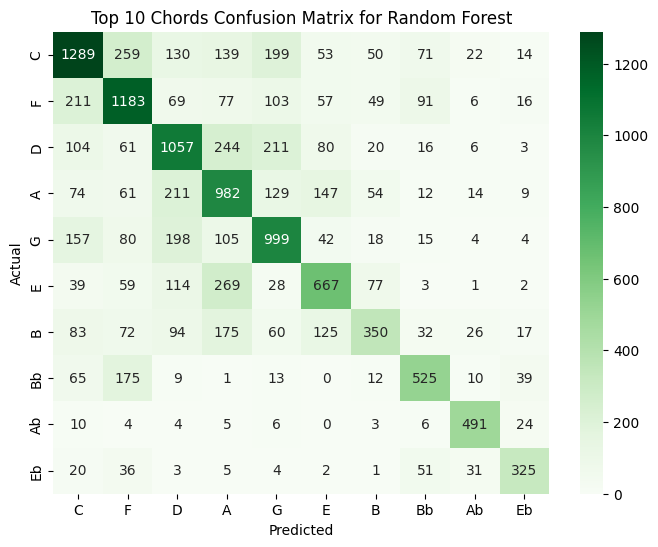

In [43]:
# Predict using Random Forest
y_pred_RFC3 = rf3.predict(X_test_RFC3)

# Find 10 most common chords in test data 
counts = Counter(y_test_RFC3)
top_10_ids = [ch for ch, _ in counts.most_common(10)]

# Only keep the top 10 from the confusion matrix 
filtered_y_test = []
filtered_y_pred = []

for true, pred in zip(y_test_RFC3, y_pred_RFC3):
    if true in top_10_ids:
        filtered_y_test.append(true)
        filtered_y_pred.append(pred)

# Build the confusion matrix 
cm = confusion_matrix(filtered_y_test, filtered_y_pred, labels=top_10_ids)

# Transform ints to chords 
labels = [int_to_chord[i] for i in top_10_ids]

# Plot with seaborn 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Top 10 Chords Confusion Matrix for Random Forest")
plt.show()

# **Using new Random Forest Classifier**


In [44]:
def predict_chord_rf3(chord1, chord2, chord3, n=1, avoid_repetition=False):
    '''
    Takes three chords as strings and outputs the n chords that would be most likely played next.
    If avoid_repetition is True, only output chords different from the input
    '''
    # Simplify chords to match the training data 
    simplified_chord1 = simplify_chord(chord1)
    simplified_chord2 = simplify_chord(chord2)
    simplified_chord3 = simplify_chord(chord3)
    
    # Check that the chords exist in the set 
    if (simplified_chord1 not in chord_distribution.keys()):
        print(f'Chord {chord1} not available')
        return None
    
    if (simplified_chord2 not in chord_distribution.keys()):
        print(f'Chord {chord2} not available')
        return None 

    if (simplified_chord3 not in chord_distribution.keys()):
        print(f'Chord {chord3} not available')
        return None 
        
    # Get the input chord's clusters 
    cluster1 = chord_to_cluster[simplified_chord1]
    cluster2 = chord_to_cluster[simplified_chord2]
    cluster3 = chord_to_cluster[simplified_chord3]

    # Put simplified chords and their cluster in a list to pass it to the model 
    vec = [[chord_to_int[simplified_chord1], 
            chord_to_int[simplified_chord2],
            chord_to_int[simplified_chord3], 
            cluster1, 
            cluster2,
            cluster3]]
    
    probs = rf3.predict_proba(vec)

    if avoid_repetition:
        # Takes the n+2 chords with highest probability 
        top_indices = np.argsort(probs[0])[::-1]
        initial_chord = [int_to_chord[i] for i in top_indices]
        
        # Replace the duplicated chords with the next best ones
        filtered_chord = [chord for chord in initial_chord if (chord != simplified_chord1) 
                          and (chord != simplified_chord2)]
        predicted_chord = filtered_chord[:n]
    
    else: 
        # Takes the n chords with highest probability 
        top_indices = np.argsort(probs[0])[-n:][::-1]
        predicted_chord = [int_to_chord[i] for i in top_indices]

    return predicted_chord

In [45]:
# Example uses 

# Common progressions  
print('Next chord prediction: ', predict_chord('C:maj', 'G:maj', 'D:maj'))    
print('Next chord prediction: ', predict_chord('G:maj', 'D:maj', 'A:maj', 3))     
print('Next chord prediction: ', predict_chord('E:maj', 'B:maj', 'C:min', 3))   
print()

# Minor key progressions 
print('Next chord prediction: ', predict_chord('A:min', 'E:min', 'D:min'))
print('Next chord prediction: ', predict_chord('F:min', 'C:min', 'G:min', 3))    
print('Next chord prediction: ', predict_chord('G:min', 'D:min', 'A:min', 3, True))               
print()

# Rare progressions 
print('Next chord prediction: ', predict_chord('C:maj', 'B:maj', 'Bb:maj'))     
print('Next chord prediction: ', predict_chord('E:maj', 'F:maj', 'Gb:maj', 3))     
print('Next chord prediction: ', predict_chord('F:dim', 'A:maj', 'C#:maj', 3, True)) 

Next chord prediction:  ['C']
Next chord prediction:  ['G', 'A', 'D']
Next chord prediction:  ['G:min', 'Bb', 'C:min']

Next chord prediction:  ['A:min']
Next chord prediction:  ['G:min', 'Ab', 'C']
Next chord prediction:  ['G', 'C', 'B']

Next chord prediction:  ['C']
Next chord prediction:  ['B', 'B:7', 'Ab:min7']
Chord C#:maj not available
Next chord prediction:  None


# **Training Ensemble Learning**

In [47]:
# Create labeled sequences of two chords
# X also contains cluster information for each chord 
# Similar to earlier Random Forest, but without clustering to match GRU
X3_ensemble = []
y3_ensemble = []

for song in list_songs:
    for i in range(len(song) - 3):
        X3_ensemble.append([chord_to_int[song[i]], 
                  chord_to_int[song[i + 1]], 
                  chord_to_int[song[i + 2]]])
        
        y3_ensemble.append(chord_to_int[song[i + 3]])

# Split data into training and testing sets for both models. 
# Using indices so they allign 
indices = np.arange(len(X3_ensemble))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

X_train_ensemble = [X3_ensemble[i] for i in train_idx]
X_test_ensemble = [X3_ensemble[i] for i in test_idx]

y_train_ensemble = [y3_ensemble[i] for i in train_idx]
y_test_ensemble = [y3_ensemble[i] for i in test_idx]

# Initiate the RF for ensemble 
rf_ensemble = RandomForestClassifier(n_estimators=300, random_state=42)
rf_ensemble.fit(X_train_ensemble, y_train_ensemble)

# Get probabilities for rf 
rf_probs = rf_ensemble.predict_proba(X_test_ensemble)


In [48]:
X_ensemble_w2v = []

# Take the three input chords in the new labeled 
# data and turn them into w2v vectors
for chords in X3_ensemble:
    word_chords = [int_to_chord[chord] for chord in chords]
    X_ensemble_w2v.append([w2v.wv[chord] for chord in word_chords])

# Split the list of vectors into the train and test data 
X_train_gru_ensemble = np.array(X_ensemble_w2v)[train_idx]
X_test_gru_ensemble = np.array(X_ensemble_w2v)[test_idx]

# Transform test into a tensor. Training is already done so no need 
X_tensor_test_gru_ens = torch.tensor(X_test_gru_ensemble, dtype=torch.float32)

# Get probabilities for GRU 
GRU_model3.eval()
with torch.no_grad():
    gru_outputs = GRU_model3(X_tensor_test_gru_ens)
    gru_probs = torch.softmax(gru_outputs, dim=1).numpy()


# **Testing Ensemble Learning**

In [49]:
# Get average of probabilities and their index for top 1 and top 3 
ensemble_probs = (gru_probs + rf_probs) / 2
ensemble_preds = np.argmax(ensemble_probs, axis=1)
top3_ensemble = np.argsort(ensemble_probs, axis=1)[:, -3:]

# Find accuracy for top 1 and top 3 
top1_acc = np.mean(ensemble_preds == np.array(y_test_ensemble))
top3_acc = np.mean([y_test_ensemble[i] in top3_ensemble[i] for i in range(len(y_test_ensemble))])

print(f"Top-1 Accuracy: {top1_acc:.2%}")
print(f"Top-3 Accuracy: {top3_acc:.2%}")


Top-1 Accuracy: 56.71%
Top-3 Accuracy: 81.51%


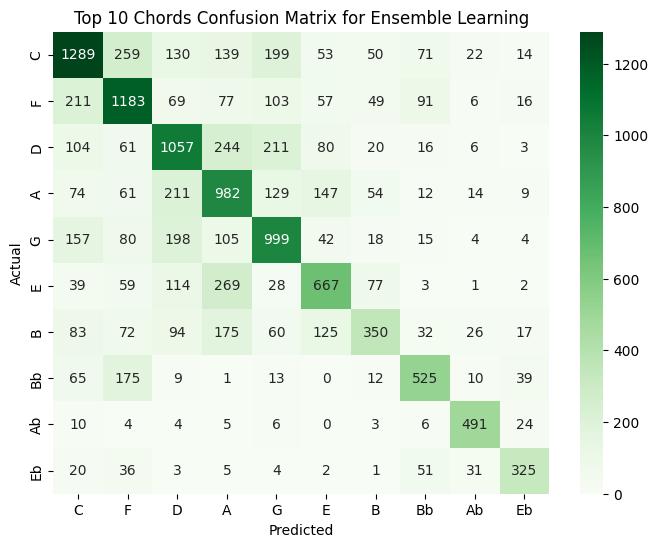

In [50]:
# 10 most common chords 
counts = Counter(y_test_ensemble)
top_10_ids = [ch for ch, _ in counts.most_common(10)]

# Keep only chords in top 10
filtered_y_test = []
filtered_y_pred = []

for true, pred in zip(y_test_ensemble, ensemble_preds):
    if true in top_10_ids:
        filtered_y_test.append(true)
        filtered_y_pred.append(pred)

# Build confusion matrix 
labels = [int_to_chord[i] for i in top_10_ids]

# Plot 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Top 10 Chords Confusion Matrix for Ensemble Learning")
plt.show()
